In [1]:
import os
import string
import pandas as pd
import numpy as np
from nltk import TreebankWordTokenizer
from keras import layers
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Lambda
from keras.preprocessing.sequence import pad_sequences
from keras import Input
from keras.layers import concatenate

from keras.models import Model, model_from_json
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping
import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
df = pd.read_csv('train.csv')[['question1', 'question2', 'is_duplicate']]

In [21]:
#indices = np.arrange(df.shape[0])
#indices.tolist()
#np.random.shuffle(indices)
data_a = df['question1']#.tolist()
data_b = df['question2']#.tolist()
label = df['is_duplicate']#.tolist()
#data_a = data_a[indices]
#data_b = data_b[indices]
#label = label[indices]
#data_a[indices]
train_sample = 60000
val_sample = 60000
train_a = data_a[:train_sample]
train_b = data_b[:train_sample]
train_label = label[:train_sample]
val_a = data_a[train_sample:train_sample+val_sample]
val_b = data_b[train_sample:train_sample+val_sample]
val_label = label[train_sample:train_sample+val_sample]

In [22]:
glove_dir = '/home/ubuntu/ml_nlp/glove_d'

In [23]:
embeddings = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype = 'float32')
    embeddings[word]=coeff
f.close()
#return embedding
#print('Found %s word vectors.' % len(embedding))

In [24]:
embeddings['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [25]:
def get_vector(word):
    if word in embeddings:
        return embeddings[word]
 
tokenizer = TreebankWordTokenizer()
def vectorise_sentence(sentence):
    #if type(sentence) == 'str':
        #tokens = word_tokenize(sentence)
        tokens = tokenizer.tokenize(sentence)
        vector = []
        for token in tokens:
            if token not in string.punctuation:
                token_vector = get_vector(token)
                if token_vector is not None:
                    vector.append(token_vector)
        return vector

def vectorize_df(dfa):
     vectorsa = [vectorise_sentence(sentence) for sentence in dfa]   
     return vectorsa

In [26]:
val_b1 = val_b[val_b.notnull()]
val_a1 = val_a[val_b.notnull()]
val_label1 = val_label[val_b.notnull()]



In [27]:
val_a_vectors = vectorize_df(val_a1)
val_b_vectors = vectorize_df(val_b1)
val_scores = val_label1.tolist()

In [28]:
train_a_vectors = vectorize_df(train_a)
train_b_vectors = vectorize_df(train_b)
train_scores = train_label.tolist()

In [29]:
train_max_a_length = len(max(train_a_vectors, key=len))
train_max_b_length = len(max(train_b_vectors, key=len))
val_max_a_length = len(max(val_a_vectors, key=len))
val_max_b_length = len(max(val_b_vectors, key=len))
max_len = max([train_max_a_length, train_max_b_length,val_max_a_length, val_max_b_length])

In [30]:
train_a_vectors = pad_sequences(train_a_vectors, padding='post', dtype='float32', maxlen=max_len)
train_b_vectors = pad_sequences(train_b_vectors, padding='post', dtype='float32', maxlen=max_len)
    

In [31]:
val_a_vectors = pad_sequences(val_a_vectors, padding='post', dtype='float32', maxlen=max_len)
val_b_vectors = pad_sequences(val_b_vectors, padding='post', dtype='float32', maxlen=max_len)

MemoryError: Unable to allocate 2.45 GiB for an array with shape (59999, 219, 50) and data type float32

In [ ]:
input_dim = 50
h_units = 100

In [ ]:
input_dim = 50 #50
h_units = 100
n_hidden = 50

lstm = layers.LSTM(n_hidden, unit_forget_bias=True, 
                               kernel_initializer='he_normal',
                               kernel_regularizer='l2',
                               name='lstm_layer')

In [ ]:
left_input = Input(shape=(None, input_dim), name='input_1')
#        left_masked_input = layers.Masking(mask_value=0)(left_input)
left_output = lstm(left_input)
right_input = Input(shape=(None, input_dim), name='input_2')
#        right_masked_input = layers.Masking(mask_value=0)(right_input)
right_output = lstm(right_input)

In [ ]:
l1_norm = lambda x: 1 - K.abs(x[0] - x[1])

In [ ]:
merged = layers.Lambda(function=l1_norm, output_shape=lambda x: x[0], 
                               name='L1_distance')([left_output, right_output])

In [ ]:
predictions = layers.Dense(1, activation='sigmoid', name='Similarity_layer')(merged)
model = Model([left_input, right_input], predictions)
optimizer = Adadelta()
model.compile(loss = 'mse', optimizer = optimizer, metrics=['accuracy'])
history = model.fit([train_a_vectors, train_b_vectors], train_scores, batch_size=64, nb_epoch=5,
                            validation_data=([val_a_vectors, val_b_vectors], val_scores))


In [41]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [42]:
n_hidden = 50
gradient_clipping_norm = 0.25
batch_size = 64
n_epoch = 10

In [43]:
lstm = LSTM(n_hidden)

In [48]:
left_input = Input(shape=(max_len,input_dim))
right_input = Input(shape=(max_len,input_dim))

In [51]:
embedding_dim = input_dim

embedding_layer = Embedding(max_len, embedding_dim, weights=[embeddings], trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)



AttributeError: 'dict' object has no attribute 'shape'

In [ ]:
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

In [49]:
#left_input =Input(shape=(None, input_dim), name='input_1')
left_output = lstm(right_input)
    
#right_input =Input(shape=(None, input_dim), name='input_2')
right_output = lstm(right_input)

In [50]:

malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])



In [51]:
malstm = Model([left_input, right_input], [malstm_distance])


In [52]:
optimizer = Adadelta()


In [53]:
malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])


In [66]:
from time import time
training_start_time = time()

In [ ]:

malstm_trained = malstm.fit([train_a_vectors, train_b_vectors], train_scores, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([val_a_vectors, val_b_vectors], val_scores))





/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/keras/backend.py", line 3722, in <genexpr>
    for ta, input_ in zip(input_ta, flatted_inputs))  File "/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py", line 193, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/keras/backend.py", line 3722, in <genexpr>
    for ta, input_ in zip(input_ta, flatted_inputs))  File "/home


Train on 40000 samples, validate on 40000 samples
Epoch 1/10
 8512/40000 [=====>........................] - ETA: 50s - loss: 0.6217 - accuracy: 0.3783

In [26]:
import datetime

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Training time finished.
5 epochs in 0:13:21.904000


In [28]:
malstm_trained.history

{'val_loss': [0.627832556610601,
  0.627832556610601,
  0.627832556610601,
  0.627832556610601,
  0.627832556610601],
 'val_accuracy': [0.3721674382686615,
  0.3721674382686615,
  0.3721674382686615,
  0.3721674382686615,
  0.3721674382686615],
 'loss': [0.6274194033813476,
  0.6274193505096436,
  0.6274192906951904,
  0.6274192132568359,
  0.6274191192626953],
 'accuracy': [0.37258, 0.37258, 0.37258, 0.37258, 0.37258]}

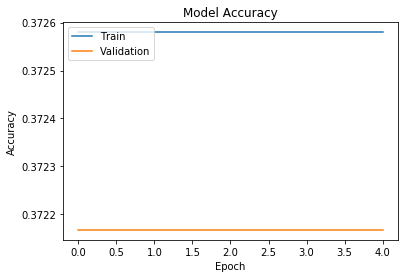

In [29]:
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [48]:
train_a_vectors[1]

array([[ 0.6185 ,  0.64254, -0.46552, ..., -0.27557,  0.30899,  0.48497],
       [ 0.418  ,  0.24968, -0.41242, ..., -0.18411, -0.11514, -0.78581],
       [ 0.48251,  0.87746, -0.23455, ..., -0.4112 ,  0.23625,  0.26451],
       ...,
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ]],
      dtype=float32)

In [49]:
train_b_vectors[1]

array([[ 0.7619  , -0.29773 ,  0.51396 , ...,  0.43088 , -0.22768 ,
         0.4026  ],
       [ 0.66979 , -0.21748 ,  0.17075 , ...,  0.38201 , -0.043277,
         0.95    ],
       [ 0.49861 , -0.12284 ,  0.44772 , ...,  0.26395 , -0.062214,
         0.6292  ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [202]:
lstm = layers.LSTM(50, unit_forget_bias=True, kernel_initializer='he_normal', kernel_regularizer='l2', name='lstm_layer')
    
left_input =Input(shape=(None, input_dim), name='input_1')
left_output = lstm(left_input)
    
right_input =Input(shape=(None, input_dim), name='input_2')
right_output = lstm(right_input)
    

In [211]:
manhattan = lambda x: K.exp(-K.sum(K.abs(x[0]-x[1]), keepdims=True, axis=1))
merged = layers.merge([left_output, right_output], mode = manhattan, output_shape = lambda x: (x[0][0],1), name='l1_distance')

    
#merged = layers.concatenate(axis=-1)([left_output, right_output], mode = manhattan, output_shape = lambda x: (x[0][0],1), name='l1_distance')

TypeError: 'module' object is not callable